In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# For saving dictionaries
import pickle

# Data visualization
import matplotlib.pyplot as plt

# For neural networks
import torch

# Computation of asset metrics
from portfolio_stats import PortfolioStats

# Time series splitting for walk forward modeling
from sklearn.model_selection import TimeSeriesSplit

# Neural network portfolio optimizer and objective functions
from workflow.tools.models import CNNPortfolioOptimizer
from workflow.tools.metrics import neg_sharpe_ratio, neg_max_return, portfolio_risk

# Transaction costs
from workflow.tools.transaction_costs import net_tc

# Tensor transform
from workflow.tools.conversion import to_tensors

# Progress bar for loops
from tqdm.auto import tqdm

from workflow.tools.utils import set_plot_style, plot_allocations

set_plot_style()

In [2]:
# Load data
kwargs = {
    "index_col": 0,
    "parse_dates": True
}

features = pd.read_csv("workflow/data/features.csv", **kwargs)

features.head()

,BONDS,COMMODITIES,STOCKS,VOLATILIITY,BONDS_RET,COMMODITIES_RET,STOCKS_RET,VOLATILIITY_RET
Date,,,,,,,,
2006-02-07,58.516796,21.282078,44.861347,13.59,-0.000699,-0.029352,-0.009784,0.041313
2006-02-08,58.487633,21.191519,45.184086,12.83,-0.000499,-0.004264,0.007168,-0.057548
2006-02-09,58.522655,21.390755,45.098011,13.12,0.000599,0.009358,-0.001907,0.022352
2006-02-10,58.399956,21.001337,45.191250,12.87,-0.002099,-0.018373,0.002065,-0.019239
2006-02-13,58.440834,20.675314,44.986847,13.35,0.000700,-0.015646,-0.004533,0.036617


In [3]:
# Define lookback window
lookback = 50
n_samples = len(features) - lookback
n_features = len(features.columns)

# Get columns related to returns, and index names
return_cols = [col for col in features.columns if "RET" in col]
indices = features.columns[~features.columns.isin(return_cols)]

# Initialize input data with zeros
X = np.zeros((n_samples, lookback, n_features))

# Extract target values starting from the lookback index
y = features[return_cols].iloc[lookback:].values

# Populate the 'X' tensor using a rolling window of size 'lookback'
for i in range(lookback, len(features)):
    X[i-lookback] = features.iloc[i-lookback:i]

X = X.transpose(0, 2, 1)

X.shape, y.shape

((4401, 8, 50), (4401, 4))

In [4]:
# Load empty optimizations dictionary
optimizations = {
    "MAX_SHARPE": {
        "OBJ": neg_sharpe_ratio,
        "WEIGHTS": [],
        "RETURNS": None
    },
    "MAX_RETURN": {
        "OBJ": neg_max_return,
        "WEIGHTS": []
    },
    "MIN_VARIANCE": {
        "OBJ": portfolio_risk,
        "WEIGHTS": [],
    }
}

# Define number of trading days per year and initialize TimeSeriesSplit
trading_days = 252
tss = TimeSeriesSplit(test_size=trading_days*2)
val_size = .2

# Loop over optimization type
for i, (opt_type, params) in enumerate(optimizations.items()):

    print(f"-- {i+1}: {opt_type} --", end="\n")

    for e, (train_idx, test_idx) in enumerate(tss.split(X)):
        
        val_idx = int(len(train_idx) * (1 - val_size))
        
        X_train, X_val, X_test = X[:val_idx], X[val_idx:], X[test_idx]
        y_train, y_val, y_test = y[:val_idx], y[val_idx:], y[test_idx]

        # Convert inputs and targets to PyTorch tensors
        X_train, X_val, X_test, y_train, y_val, y_test = to_tensors(
            X_train, X_val, X_test, y_train, y_val, y_test
        )

        # Define input size, hidden size, and output size
        input_channels = X_train.shape[1]       # 8 features
        hidden_size = 64                     # 64 neurons
        output_size = y_train.shape[-1]      # 4 assets

        # Define number of training epochs
        epochs = 100

        # Instantiate model and optimizer
        model = CNNPortfolioOptimizer(input_channels, hidden_size, output_size)
        optimizer = torch.optim.Adam(model.parameters())

        # Construct training loop
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            obj = params["OBJ"](outputs, y_train)
            obj.backward()
            optimizer.step()

            with torch.no_grad():
                val_allocations = model(X_val)
                val_obj = params["OBJ"](val_allocations, y_val)

            print(
                f"Split {e+1}: Epoch {epoch+1}/{epochs} ({(epoch+1)/epochs*100:,.2f}%)",
                "|",
                f"Train: {obj.item():,.5f}", 
                f"Val: {val_obj.item():,.5f}" ,
                end="\r"
            )

        print()
        
        # Get the outputs (asset allocations) after training
        with torch.no_grad():
            model_allocations = model(X_test)
            optimizations[opt_type]["WEIGHTS"].append(model_allocations)
    
    print()

-- 1: MAX_SHARPE --
Split 1: Epoch 100/100 (100.00%) | Train: -2.09412 Val: -0.74684
Split 2: Epoch 100/100 (100.00%) | Train: -1.52377 Val: -0.13787
Split 3: Epoch 100/100 (100.00%) | Train: -1.14597 Val: -0.57747
Split 4: Epoch 100/100 (100.00%) | Train: -0.31339 Val: -0.37989
Split 5: Epoch 100/100 (100.00%) | Train: -1.00041 Val: -0.47630

-- 2: MAX_RETURN --
Split 1: Epoch 100/100 (100.00%) | Train: -0.60508 Val: -0.25022
Split 2: Epoch 100/100 (100.00%) | Train: -0.42386 Val: -0.22519
Split 3: Epoch 100/100 (100.00%) | Train: -0.47456 Val: -0.05153
Split 4: Epoch 100/100 (100.00%) | Train: -0.07404 Val: -0.10738
Split 5: Epoch 100/100 (100.00%) | Train: -0.49081 Val: -0.22146

-- 3: MIN_VARIANCE --
Split 1: Epoch 100/100 (100.00%) | Train: 0.19758 Val: 0.16812
Split 2: Epoch 100/100 (100.00%) | Train: 0.04437 Val: 0.04918
Split 3: Epoch 100/100 (100.00%) | Train: 0.18469 Val: 0.18297
Split 4: Epoch 100/100 (100.00%) | Train: 0.11957 Val: 0.16885
Split 5: Epoch 100/100 (100.00%) |

In [5]:
# Initialize empty list for dataframe concatenation
optimized_returns = []

# Compute the returns for each optimized portfolio
for opt_type, params in optimizations.items():
    weights = np.concatenate(params["WEIGHTS"])

    # Reindex features to match weights
    reindexed_features = features.iloc[-len(weights):]
    weights = pd.DataFrame(weights, index=reindexed_features.index, columns=indices)

    # Shift weights for real time information lag
    weights = weights.shift().dropna()

    reindexed_returns = reindexed_features[return_cols][1:]
    reindexed_returns.columns = indices

    # Portfolio returns = sum of (weights * returns)
    returns = (weights * reindexed_returns).sum(axis=1)
    returns = net_tc(returns, weights, cost_rate=0.005)
    returns.name = opt_type

    params["WEIGHTS"] = weights
    params["RETURNS"] = returns
    optimized_returns.append(returns)

# Concatenate optimized returns
optimized_returns = pd.concat(optimized_returns, axis=1)
optimized_returns.loc[optimized_returns.index.min()] = 0

market_rets = features["STOCKS_RET"].reindex(optimized_returns.index)
market_rets.name = "STOCK_MARKET"
market_rets.loc[market_rets.index.min()] = 0

backtest = pd.concat([optimized_returns, market_rets], axis=1)

backtest.head()

,MAX_SHARPE,MAX_RETURN,MIN_VARIANCE,STOCK_MARKET
Date,,,,
2013-10-10,0.000000,0.000000,0.000000,0.000000
2013-10-11,0.004070,-0.045922,0.004046,0.007014
2013-10-14,0.004285,0.021355,0.003157,0.004387
2013-10-15,-0.000629,0.144928,-0.006844,-0.007662
2013-10-16,0.000445,-0.232674,0.012213,0.013928


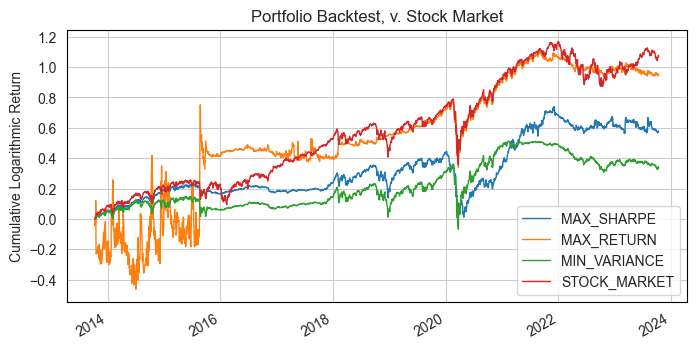

In [6]:
backtest.cumsum().plot(figsize=(8, 4))
plt.title("Portfolio Backtest, v. Stock Market")
plt.ylabel("Cumulative Logarithmic Return")
plt.xlabel("")
plt.show()

In [7]:
optimized_stats = PortfolioStats(backtest, log=True)

optimized_stats.info.sort_values(by="SHARPE", ascending=False)

,SHARPE,CUMU_RET,ANN_RET,ANN_VOL,MAX_DD
STOCK_MARKET,0.597574,1.069277,0.10697,0.179007,-0.430787
MAX_SHARPE,0.422352,0.571145,0.057137,0.135283,-0.433019
MIN_VARIANCE,0.23298,0.334193,0.033433,0.143499,-0.424545
MAX_RETURN,0.185383,0.944336,0.094471,0.5096,-0.721038


In [8]:
for col in optimized_stats.info.columns:
    print("--", col, "--")
    print(optimized_stats.info[col].sort_values(ascending=False)[:1])
    print()

-- SHARPE --
STOCK_MARKET    0.597574
Name: SHARPE, dtype: object

-- CUMU_RET --
STOCK_MARKET    1.069277
Name: CUMU_RET, dtype: object

-- ANN_RET --
STOCK_MARKET    0.10697
Name: ANN_RET, dtype: object

-- ANN_VOL --
MAX_RETURN    0.5096
Name: ANN_VOL, dtype: object

-- MAX_DD --
MIN_VARIANCE   -0.424545
Name: MAX_DD, dtype: object



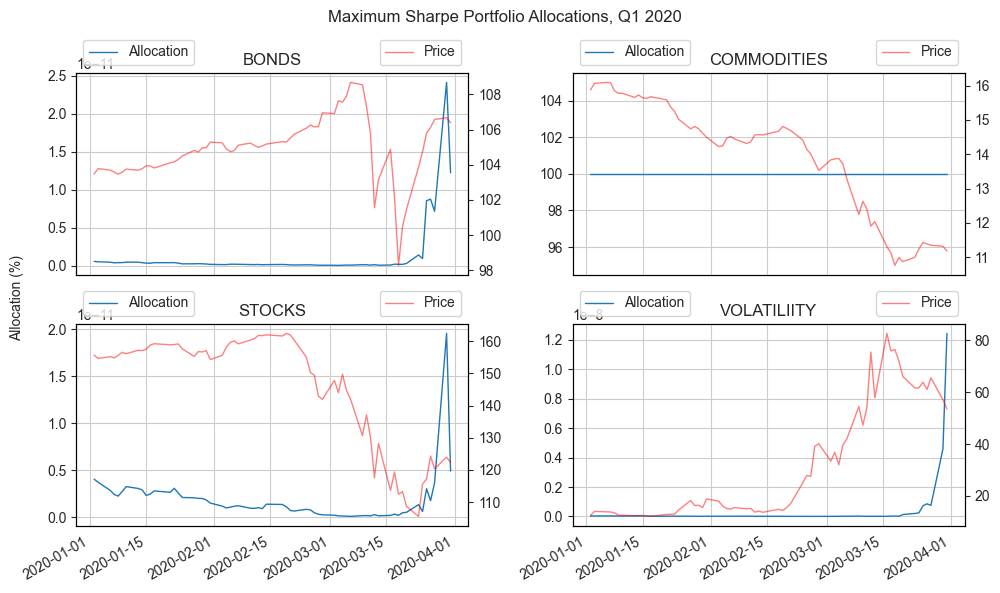

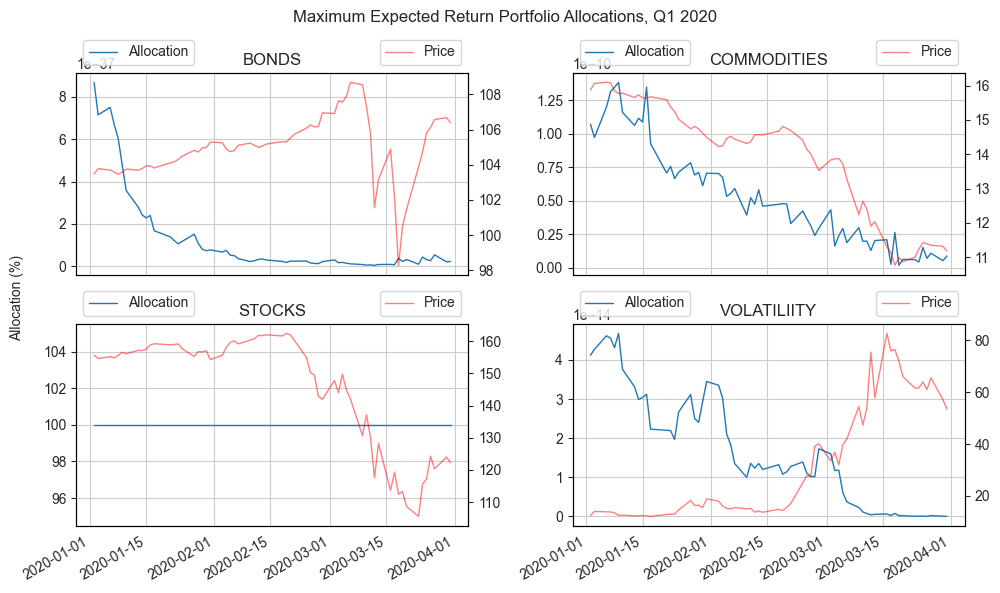

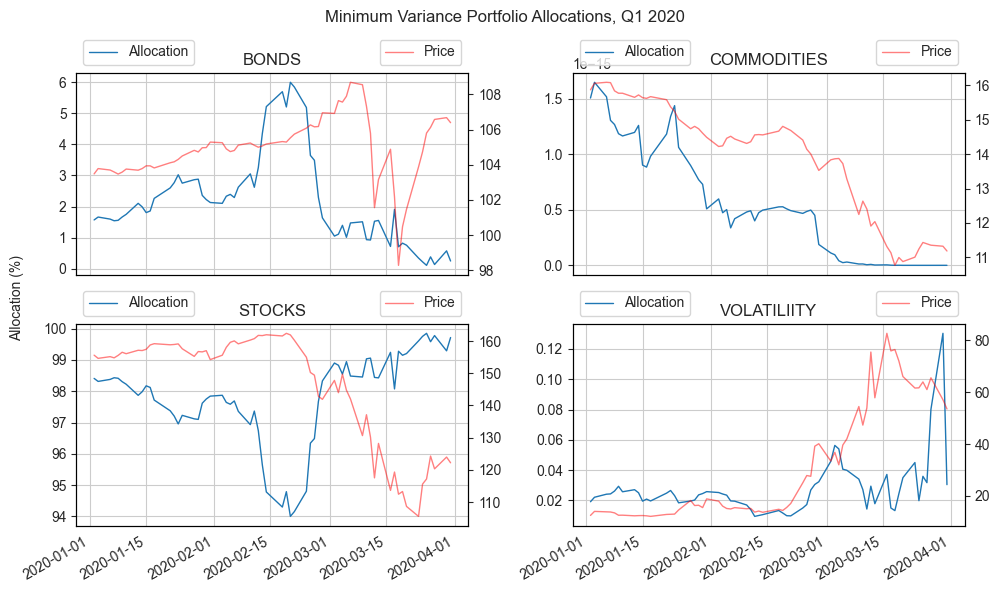

In [9]:
covid_q1 = {"start": "2020-01", "end": "2020-03"}

titles = [
    "Maximum Sharpe Portfolio Allocations, Q1 2020",
    "Maximum Expected Return Portfolio Allocations, Q1 2020",
    "Minimum Variance Portfolio Allocations, Q1 2020",
]

for i, opt_type in enumerate(optimizations.keys()):
    plot_allocations(optimizations[opt_type], features, indices, covid_q1, titles[i])

In [10]:
# Save files
backtest.to_csv("workflow/data/backtests/cnn_bt.csv")
with open("workflow/data/optimizations/cnn_opt.pkl", "wb") as f:
    pickle.dump(optimizations, f)